Не стал пересчитывать вложения с учетом инфляции, так как хотел посмотреть не только на первоначальные вложения, но и на распределение их по балансу.
В процентах боялся запутаться, но думаю что если учесть инфляцию, то результат просто станет лучше.

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor, LogisticRegressionCV, LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import preprocessing
from tqdm.notebook import tqdm
from autoviz.AutoViz_Class import AutoViz_Class
import datetime
from time import sleep, time
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ModuleNotFoundError: No module named 'autoviz'

In [ ]:
RANDOM_SEED = 42

In [ ]:
# def na_info(ds: pd.DataFrame) -> pd.DataFrame:
#     arr = []
#     nans_cnt = ds.isna().sum()
#     for ind, row in tqdm(nans_cnt.items(), total=nans_cnt.shape[0]):
#         name = ind
#         if ind.startswith('ind_'):
#             name = buh_codes_dict[ind[4:8]]
#         arr.append([ind, name, row, round(row / data.shape[0] * 100, 2)])
#     return pd.DataFrame(arr, columns=['column', 'name', 'nan_cnt', 'nan_perc'])


def show_num_corr(df: pd.DataFrame, features: list = None, title: str ='Корреляция между данными'):
    '''
    Корреляция между числовыми признаками набора данных
    :param df: Набор данных
    :param features: признаки
    :param title: Заголовок карты
    :return: Корр карта признаков
    '''
    plt.figure(figsize=(16, 16))
    show_df =  df
    if features is not None:
        show_df = df[features]
    mask = np.triu(np.ones_like(show_df.corr(), dtype=bool))
    heatmap = sns.heatmap(show_df.corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)
    return heatmap


def get_high_coreleted_features(df: pd.DataFrame, limit: float = 0.9, method: str = 'pearson') -> pd.DataFrame:
    '''
    Получить сильно скоррелированные признаки
    :param df: Набор данных
    :param limit: только те, корреляция которых превышает лимит
    :param method: метод вычисления корреляции
    :return: Наобор вида (признак1, признак2, коэфф корреляции)
    '''
    corr_ds = df.corr(method=method)
    corr_rows = []
    for ind_row, row in corr_ds.iterrows():
        for ind_col, cell in row.items():
            if abs(cell) > limit and ind_row != ind_col:
                if [ind_col, ind_row, cell] not in corr_rows:
                    corr_rows.append([ind_row, ind_col, cell])
    return pd.DataFrame(corr_rows, columns=['feature_1', 'feature_2', 'value'])


def outliers(df: pd.DataFrame, feature: str, iqrs: float = 1.5) -> pd.DataFrame:
    '''
    Получение выбросов по интерквартильному размаху
    :param df: Набор данных
    :param feature: Признак для которого ищем выбросы
    :param iqrs: Все что выходит за  IQR * iqrs
    :return: набор данных с выбросами
    '''
    # Интерквартильный размах
    perc25 = df[feature].quantile(0.25)
    perc75 = df[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - iqrs * IQR, perc75 + iqrs * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return df[(df[feature] < low) | (df[feature] > high)]


def first_look(s: pd.Series) -> None:
    '''
    EDA для признаков
    :param s: Колонка признака
    :return: None
    '''
    saved_format = pd.options.display.float_format
    pd.options.display.float_format = '{:.2f}'.format
    print('-' * 80)
    try:
        print('Название:', s.name)
        print('Тип данных:', s.dtype.type)
        print('Количество значений:', len(s))
        print('Количество уникальных значений:', s.nunique())
        print('Количество пропусков:', s.isna().sum())
        print(f'Процент пропусков: {round((s.isna().sum() / len(s)) * 100, 2)}%')
        print('Общие статистики:')
        print(s.describe())
        print('Топ 10 уникальных значений:')
        print(s.value_counts()[:10])
    except Exception as e:
        print('Ошибка:', str(e))
    print('-' * 80)
    pd.options.display.float_format = saved_format


def plot_feature_importances(fi, columns: list, num: int=20) -> None:
    '''
    График важности признаков для моделей с feature_importances
    :param fi: feature_importances
    :param columns: какие признаки смотрим
    :param num: сколько самых важных выводим
    :return: None
    '''
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(fi, index=columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


def show_roc_auc(y_test: list, probs: list) -> None:
    '''
    График ROC AUC
    :param y_test: Истенные значения
    :param probs: Предсказанные вероятности
    :return: None
    '''
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure(figsize=(12, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()


def show_lr_Importance(model: LogisticRegression, features: list, n: int=20) -> None:
    '''
    График важности признаков для моделей с LR
    :param model: экземпляр LR
    :param features: какие признаки смотрим
    :param n: сколько самых важных выводим
    :return:
    '''
    lr_coef = pd.DataFrame(model.coef_.T, columns=['coefficient'], index=features)
    lr_coef = np.abs(lr_coef)
    lr_coef = lr_coef.sort_values(by='coefficient', ascending=False)
    f, ax = plt.subplots(1, 1, figsize=(16, 10))
    df4display = lr_coef.head(n)
    sns.barplot(x=df4display['coefficient'], y=df4display.index, palette="vlag", ax=ax)
    _ = ax.set_ylabel("Признак")
    _ = ax.set_title("Значимость признаков")


def show_confusion_matrix(y_pred: list, y_true: list) -> None:
    '''
    Матрица смежности для предсказаний классификатора
    :param y_pred: предсказанные значения
    :param y_true: истинные значения
    :return:
    '''
    plt.figure(figsize=(8, 8))
    c_matrix = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    heatmap = sns.heatmap(c_matrix, annot=True, cmap='BrBG', fmt='g', annot_kws={"fontsize": 18})
    heatmap = heatmap.set_title("Confusion matrix", fontdict={'fontsize': 18}, pad=16)


def print_clssification_metrix(y_pred: list, y_true: list):
    '''
    Метрики качества для классификатора
    :param y_pred:
    :param y_true:
    :return:
    '''
    print('Precision:', metrics.precision_score(y_pred, y_true))
    print('Recall:', metrics.recall_score(y_pred, y_true))
    print('F1-score:', metrics.f1_score(y_pred, y_true))


In [ ]:
def combine_equals(df):
    # Есть странные колонки заканчивающиеся на .1 и .2 - объединяем с нормальным кодом
    for col in [c for c in df.columns if c.endswith('.1') or c.endswith('.2')]:
        if col[0:8] in df.columns :
            df[col[0:8]] = df[col[0:8]] + df[col]
            df.drop(col, axis=1, inplace=True)

In [2]:
data = pd.read_csv('data/dataset4ds.csv')
data.head()

,name,shortname,type,category,region,date_addmsp,okved,status,date_open,org_inn,...,ind_6321,ind_6322,ind_6323,ind_6324,ind_6325,ind_6326,ind_6330,ind_6350,ind_6300,ind_6400
0,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОМИ...","ООО ""КОМИПЕРМДОРСТРОЙ""",ЮЛ,Среднее предприятие,77,2016-01-08,71.1,Действует,2002-06-17,1101034216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
data_spb = pd.read_csv('data/df_spb_all_upd.csv')
combine_equals(data_spb)
data_spb.head()

,inn,ogrn,main_okved,name,address,type,status,okved,date_reg,comments,...,founding_year,founding_month,name_okved,currency,inflation_by_2022,investments,inflation,total_profit,breaking_even,payback_time
0,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,60.9579,1.4904,10.000000,1.1291,22,1,1
1,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,67.0349,1.3200,11.291000,1.0538,57,1,1
2,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,58.3529,1.2527,11.898456,1.0252,148,1,1
3,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,62.7078,1.2218,12.198297,1.0427,430,1,1
4,7813213777,1157847038062,62.01,"ООО ""СТИЛЬ""","194044, г. Санкт-Петербург, пр-кт Большой Сампсониевский, 47 литер а, кв. 107",коммерческая,в процессе ликвидации,"['26.20', '26.51.8', '62.02', '62.09', '63.11', '63.11.1']",2015-02-06,Организация находится в стадии ликвидидации с 12.10.2021.,...,2015,2,Разработка компьютерного программного обеспечения,64.7362,1.1718,12.719164,1.0305,677,1,1


In [170]:
# Колонки в наборе отличаются по кол-ву
diff_columns = list(set(data_msk.columns).symmetric_difference(set(data_spb.columns)))
data_msk.drop(diff_columns, axis=1, inplace=True, errors='ignore')
data_spb.drop(diff_columns, axis=1, inplace=True, errors='ignore')
set(data_msk.columns).symmetric_difference(set(data_spb.columns))

set()

In [171]:
# И по порядку следования
data_msk = data_msk.reindex(sorted(data_msk.columns), axis=1)
data_spb = data_spb.reindex(sorted(data_msk.columns), axis=1)
np.sum(data_msk.columns != data_spb.columns)

0

In [172]:
data_msk['region'] = 'msk'
data_spb['region'] = 'spb'
data = pd.concat([data_msk, data_spb]).reset_index(drop=True)
data.head()

,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,ind_1100,...,name,name_okved,ogrn,okved,payback_time,status,total_profit,type,year,region
0,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",67.0349,2016-02-15,2,2016,11796,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2016,msk
1,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",58.3529,2016-02-15,2,2016,11338,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2017,msk
2,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",62.7078,2016-02-15,2,2016,10748,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2018,msk
3,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",64.7362,2016-02-15,2,2016,10261,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2019,msk
4,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",72.1464,2016-02-15,2,2016,9735,...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ВЫСШЕГО ОБРАЗОВАНИЯ «ИНСТИТУТ НЕПРЕРЫВНОГО ОБРАЗОВАНИЯ»,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2020,msk


In [173]:
#data = pd.read_csv('data/df_spb_all_upd.csv')

In [174]:
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85684 entries, 0 to 85683
Data columns (total 122 columns):
 #    Column             Non-Null Count  Dtype  
---   ------             --------------  -----  
 0    address            85684 non-null  object 
 1    bankrupt           85684 non-null  int64  
 2    breaking_even      85684 non-null  int64  
 3    com_uncom          85684 non-null  int64  
 4    comments           16310 non-null  object 
 5    currency           85684 non-null  float64
 6    date_reg           85684 non-null  object 
 7    founding_month     85684 non-null  int64  
 8    founding_year      85684 non-null  int64  
 9    ind_1100           85684 non-null  int64  
 10   ind_1110           85684 non-null  int64  
 11   ind_1120           85684 non-null  int64  
 12   ind_1130           85684 non-null  int64  
 13   ind_1140           85684 non-null  int64  
 14   ind_1150           85684 non-null  int64  
 15   ind_1160           85684 non-null  int64  
 16   in

In [175]:
# Сразу типмизируем, чтоб не путаться
data['inn'] = data['inn'].astype(str)
data['ogrn'] = data['ogrn'].astype(str)
data['main_okved'] = data['main_okved'].astype(str)
data['name'] = data['name'].astype(str)
data['address'] = data['address'].astype(str)
data['type'] = data['type'].astype(str)
data['status'] = data['status'].astype(str)
#data['okved'] = data['okved'].apply(lambda x: x[1:-1].split(','))
data['date_reg'] = pd.to_datetime(data['date_reg'])
data['comments'] = data['comments'].astype(str)
data['year'] = data['year'].astype(int)
data[[c for c in data.columns if c.startswith('ind_')]] = data[[c for c in data.columns if c.startswith('ind_')]].astype(float)
data.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85684 entries, 0 to 85683
Data columns (total 122 columns):
 #    Column             Non-Null Count  Dtype         
---   ------             --------------  -----         
 0    address            85684 non-null  object        
 1    bankrupt           85684 non-null  int64         
 2    breaking_even      85684 non-null  int64         
 3    com_uncom          85684 non-null  int64         
 4    comments           85684 non-null  object        
 5    currency           85684 non-null  float64       
 6    date_reg           85684 non-null  datetime64[ns]
 7    founding_month     85684 non-null  int64         
 8    founding_year      85684 non-null  int64         
 9    ind_1100           85684 non-null  float64       
 10   ind_1110           85684 non-null  float64       
 11   ind_1120           85684 non-null  float64       
 12   ind_1130           85684 non-null  float64       
 13   ind_1140           85684 non-null  float64  

In [176]:
data = data[data['year'] < 2020]

In [177]:
for col in [c for c in data.columns if c.startswith('ind_')]:
    data[col] = data[col] / data['currency']

In [178]:
# Год когда появилась первая отчетность компании
first_year = data.groupby(['inn'])['year'].min().rename('first_year')
data.drop('first_year', axis=1, inplace=True, errors='ignore')
data = data.join(first_year, on='inn')
data.head()

,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,ind_1100,...,name_okved,ogrn,okved,payback_time,status,total_profit,type,year,region,first_year
0,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",67.0349,2016-02-15,2,2016,175.968041,...,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2016,msk,2016
1,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",58.3529,2016-02-15,2,2016,194.300540,...,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2017,msk,2016
2,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",62.7078,2016-02-15,2,2016,171.398135,...,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2018,msk,2016
3,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",64.7362,2016-02-15,2,2016,158.504824,...,Образование высшее,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2019,msk,2016
5,"117105, г. Москва, проезд Нагорный, 5, эт. 2 каб. 213",0,0,1,nan,29.3874,2011-05-26,5,2011,12.250148,...,Разработка компьютерного программного обеспечения,1117746406810,"['62.02', '62.09', '63.11.1', '70.22', '71.11.1', '72.19', '85.42.9', '95.11']",-1,действующая,-1771,коммерческая,2011,msk,2011


In [179]:
# Год когда была последняя отчетность компании
last_year = data.groupby(['inn'])['year'].max().rename('last_year')
data.drop('last_year', axis=1, inplace=True, errors='ignore')
data = data.join(last_year, on='inn')
data.head()

,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,ind_1100,...,ogrn,okved,payback_time,status,total_profit,type,year,region,first_year,last_year
0,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",67.0349,2016-02-15,2,2016,175.968041,...,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2016,msk,2016,2019
1,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",58.3529,2016-02-15,2,2016,194.300540,...,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2017,msk,2016,2019
2,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",62.7078,2016-02-15,2,2016,171.398135,...,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2018,msk,2016,2019
3,"109542, г. Москва, пр-кт Рязанский, 86/1",0,0,0,"Обратите внимание, АНО ВО ""ИНО"" является некоммерческой организацией, то есть извлечение прибыли для нее не является основной целью.",64.7362,2016-02-15,2,2016,158.504824,...,1167700052233,"['18.11', '18.12', '18.14', '18.20', '52.10', '55.20', '55.90', '56.29', '58.11', '58.13']",-1,действующая,0,некоммерческая унитарная,2019,msk,2016,2019
5,"117105, г. Москва, проезд Нагорный, 5, эт. 2 каб. 213",0,0,1,nan,29.3874,2011-05-26,5,2011,12.250148,...,1117746406810,"['62.02', '62.09', '63.11.1', '70.22', '71.11.1', '72.19', '85.42.9', '95.11']",-1,действующая,-1771,коммерческая,2011,msk,2011,2019


In [180]:
# Берем все признаки из самого раннего года организации - объединяем с основным набором
additional_features = [c for c in data.columns if c.startswith('ind_')]
additional_features.remove('ind_1600')
# additional_features.remove('ind_2400')
investments = data.sort_values(by=['inn', 'year']).groupby('inn').first()[['year', 'ind_1600'] + additional_features]
investments.columns = ['inv_year', 'inv_sum'] + ['inv_' + x for x in additional_features]
data.drop(investments.columns, axis=1, inplace=True, errors='ignore')
data = data.join(investments, on=['inn'])
data[['inn', 'year'] + investments.columns.tolist()].head() #.sort_values(by=['inn', 'year']).head()

,inn,year,inv_year,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
0,7721452574,2016,2016,300.664281,175.968041,0.119341,0.0,0.0,0.0,351.697399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7721452574,2017,2016,300.664281,175.968041,0.119341,0.0,0.0,0.0,351.697399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7721452574,2018,2016,300.664281,175.968041,0.119341,0.0,0.0,0.0,351.697399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7721452574,2019,2016,300.664281,175.968041,0.119341,0.0,0.0,0.0,351.697399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,7726676916,2011,2011,1368.409591,12.250148,0.000000,0.0,0.0,0.0,5.988961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
data.loc[data['inv_sum'] < 0, ['inv_sum', 'inn', 'date_reg']]

,inv_sum,inn,date_reg
2701,-0.159470,9731000027,2018-04-09
2702,-0.159470,9731000027,2018-04-09
3952,-0.085686,9715309555,2017-11-29
3953,-0.085686,9715309555,2017-11-29
3954,-0.085686,9715309555,2017-11-29
4033,-1.028227,7720403398,2017-11-20
4034,-1.028227,7720403398,2017-11-20
4035,-1.028227,7720403398,2017-11-20
4500,-1.182461,7725394098,2017-09-13
4501,-1.182461,7725394098,2017-09-13


In [182]:
# Накопительно вычисляем сумму прибыли организации по годам - объединяем с набором
profit = data.sort_values(by=['inn', 'year']).groupby('inn').cumsum()['ind_2400']
profit.name = 'profit'
data.drop(['profit'], axis=1, inplace=True, errors='ignore')
data = data.join(profit)
data[['inn', 'year', 'ind_2400', 'profit'] + investments.columns.tolist()].sort_values(by=['inn', 'year']).head()

,inn,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
57635,1102068218,2011,130.055738,130.055738,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57636,1102068218,2012,-72.202747,57.852992,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57637,1102068218,2013,-74.290379,-16.437388,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57638,1102068218,2014,-29.462517,-45.899905,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57639,1102068218,2015,-30.676910,-76.576815,2011,2346.141544,2309.323043,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
data.sort_values(by=['inn', 'year']).groupby('inn').last()[['year', 'ind_2400', 'profit'] + investments.columns.tolist()].head()

,year,ind_2400,profit,inv_year,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
inn,,,,,,,,,,,,,,,,,,,,,
1102068218,2019,0.030895,32.442349,2011,2346.141544,2309.323043,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1650329732,2019,14.304207,19.947110,2016,30.939108,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1655298774,2019,257.429383,866.196041,2014,181.433929,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1655300448,2019,0.108131,31.902896,2014,32.299456,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2310172571,2019,189.383992,591.200701,2013,162.647576,30.174579,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
features = ['year', 'ind_2400', 'profit', 'result',] + investments.columns.tolist()

In [185]:
# Формируем результат деятельности организации за год как разницу между первоначальным вложением и прбылью после налогов
data['result'] = data['inv_sum'] - data['profit']
data.sample(2)

,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,ind_1100,...,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400,profit,result
16816,"119571, г. Москва, пр-кт Ленинский, 158, помещ. II комн. №100",0,0,1,nan,58.3529,2016-01-29,1,2016,149.504138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.431705,177.349834
81294,"197101, г. Санкт-Петербург, ул. Рентгена, 7 литера а, помещ. 1-н часть 133",0,1,1,nan,64.7362,2016-02-03,2,2016,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1592.381762,-1491.941543


In [186]:
# Объединяем во временный набор последние записи об организации и записи где организаци вышла в 0 плюс
# затем берем ту что была раньше
temp = pd.concat([data.sort_values(by=['inn', 'year']).groupby('inn').last(),
           data[data['result'] <= 0].sort_values(by=['inn', 'year']).groupby('inn').first()]).reset_index()
temp = temp.sort_values(by=['inn', 'year']).groupby(['inn']).first().reset_index()
temp.sample(2) #[['inn'] + features]

,inn,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,...,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400,profit,result
4188,7717780565,"129301, г. Москва, ул. Бориса Галушкина, 18, кв. 275",1,1,1,Организация ликвидирована 26.02.2019.,58.3529,2014-04-01,4,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.244423,-0.329724
15998,9729074247,"125252, г. Москва, ул. Авиаконструктора Микояна, 12, пом XVIII ком 1,2",0,0,1,nan,64.7362,2017-04-14,4,2017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-794.449060,1289.814329


In [187]:
# Формироуем таргет как разницу межу годом выхода в плюс и годом инвестирования или -1 если так и не вашли в плюс
temp['target'] = temp.apply(lambda row: -1 if row['result'] > 0 else row['year'] - row['inv_year'], axis=1)
temp.sample(2)

,inn,address,bankrupt,breaking_even,com_uncom,comments,currency,date_reg,founding_month,founding_year,...,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400,profit,result,target
6118,7724435778,"115573, г. Москва, проезд Ореховый, 11, кв. 43",1,0,1,Организация ликвидирована 02.06.2020.,64.7362,2018-04-03,4,2018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.918297,1.786062,-1
1633,7705540640,"115093, г. Москва, ул. Люсиновская, 9",0,0,1,nan,64.7362,2013-05-21,5,2013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.724791,20.003418,-1


In [188]:
# В рабочий набор берем только коммерческие организации
work_df = temp.loc[temp['type'] == 'коммерческая', ['inn', 'main_okved', 'date_reg', 'inv_sum', 'target', 'region', 'year', 'first_year', 'last_year'] + ['inv_' + x for x in additional_features]]
work_df.head()

,inn,main_okved,date_reg,inv_sum,target,region,year,first_year,last_year,inv_ind_1100,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
0,1102068218,62.01,2011-04-04,2346.141544,-1,msk,2019,2011,2019,2309.323043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1650329732,62.01,2016-04-25,30.939108,-1,msk,2019,2016,2019,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1655298774,62.01,2014-08-12,181.433929,1,msk,2015,2014,2019,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1655300448,62.09,2014-09-05,32.299456,1,msk,2015,2014,2019,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2310172571,62.09,2013-09-09,162.647576,5,msk,2018,2013,2019,30.174579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA

In [189]:
for f in work_df.columns:
    first_look(work_df[f])

--------------------------------------------------------------------------------
Название: inn
Тип данных: <class 'numpy.object_'>
Количество значений: 16083
Количество уникальных значений: 16083
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count          16083
unique         16083
top       1102068218
freq               1
Name: inn, dtype: object
Топ 10 уникальных значений:
1102068218    1
7804528072    1
7804513164    1
7804513735    1
7804513781    1
7804513990    1
7804514697    1
7804514922    1
7804515490    1
7804515764    1
Name: inn, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Название: main_okved
Тип данных: <class 'numpy.object_'>
Количество значений: 16083
Количество уникальных значений: 66
Количество пропусков: 0
Процент пропусков: 0.0%
Общие статистики:
count     16083
unique       66
top       62.01
freq       5390
Name: 

### Feature engineering

In [190]:
work_df = work_df[work_df['inv_sum'] > 0]

In [191]:
# np.log(work_df['inv_sum']).hist(bins=100)

In [192]:
work_df['inv_sum'] = np.log(work_df['inv_sum'])

In [193]:
work_df['inv_month'] = work_df['date_reg'].dt.month

In [194]:
# work_df['target'] = work_df['target'].apply(lambda x: x if x <= 5 else 5)

In [195]:
work_df.to_csv('out/test4rosstat.csv', index=False)

### Первая модель - LR

In [196]:
# Формируем X
# Масштабируем числовые признаки
X = pd.DataFrame([], index=work_df.index)
X[['inv_sum'] + ['inv_' + x for x in additional_features]] = preprocessing.StandardScaler().fit_transform(work_df[['inv_sum'] + ['inv_' + x for x in additional_features]])
X.sample(2)

,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,...,inv_ind_4500,inv_ind_6100,inv_ind_6220,inv_ind_6240,inv_ind_6250,inv_ind_6310,inv_ind_6320,inv_ind_6330,inv_ind_6350,inv_ind_6400
16023,1.447503,-0.010106,-0.008665,-0.026793,0.0,0.0,-0.024999,-0.013764,-0.017312,-0.03129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2235,0.359500,-0.010106,-0.008665,-0.026793,0.0,0.0,-0.024999,-0.013764,-0.017312,-0.03129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
# Кодируем категориальные признаки
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'region']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'region']]).astype(int)
X.sample(2)

,inv_sum,inv_ind_1100,inv_ind_1110,inv_ind_1120,inv_ind_1130,inv_ind_1140,inv_ind_1150,inv_ind_1160,inv_ind_1170,inv_ind_1180,...,x0_90.04,x0_91.01,x0_91.02,x0_91.03,x0_91.04,x0_93.1,x0_93.2,x0_94.12,x1_msk,x1_spb
14673,0.444170,-0.010106,-0.008665,-0.026793,0.0,0.0,-0.024999,-0.013764,-0.017312,-0.03129,...,0,0,0,0,0,0,0,0,1,0
13350,-0.608332,-0.010106,-0.008665,-0.026793,0.0,0.0,-0.024999,-0.013764,-0.017312,-0.03129,...,1,0,0,0,0,0,0,0,0,1


In [198]:
# В таргет берем только признак окупиться/не окупится
y = (work_df['target'] != -1).astype(int)
y.unique()

array([0, 1])

In [199]:
# Бъем на трейн - тест
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((13942, 166), (13942,), (11153, 166), (11153,), (2789, 166), (2789,))

In [200]:
# Теперь моделька
lr = LogisticRegressionCV(Cs=10, random_state=RANDOM_SEED, class_weight='balanced')
lr.fit(X_train, y_train)
y_prob = lr.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.6982594951362799

В принципе результат не плохой - можно работать дальше

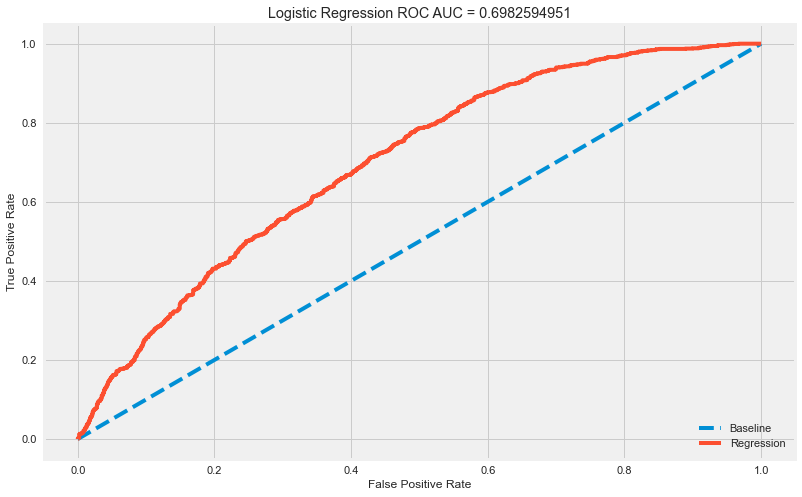

In [201]:
show_roc_auc(y_valid, y_prob[:, 1])

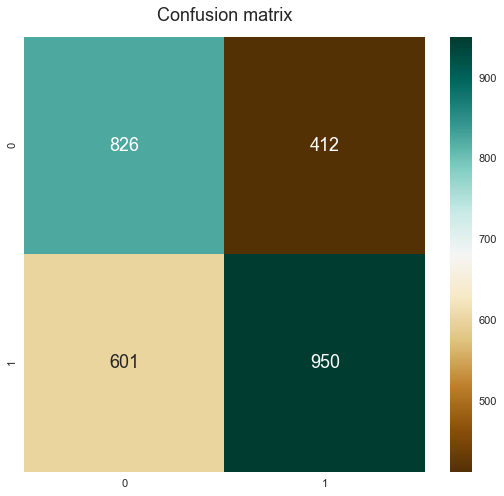

In [202]:
y_pred = lr.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

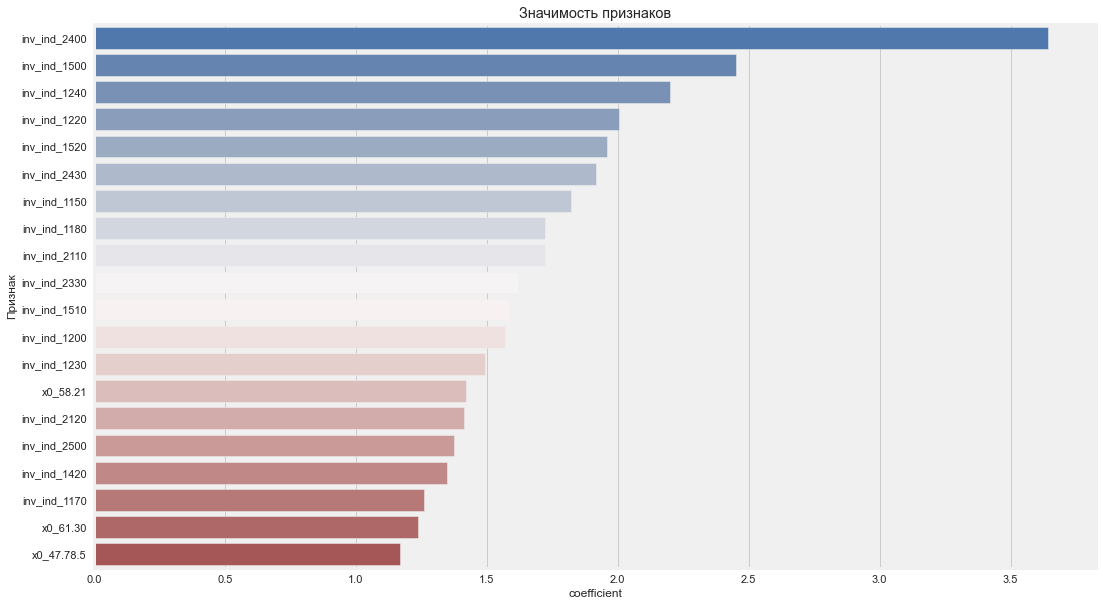

In [203]:
show_lr_Importance(lr, X.columns)

In [204]:
# По замечаниям - проверка на переобучение
y_prob = lr.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.7025259919531611

### LGBMClassifier

In [205]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced', max_depth=3)
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob[:, 1])

0.7412040910199457

Результат еще лучше, но нас интересует не просто выйдет или нет из убытков, а срок

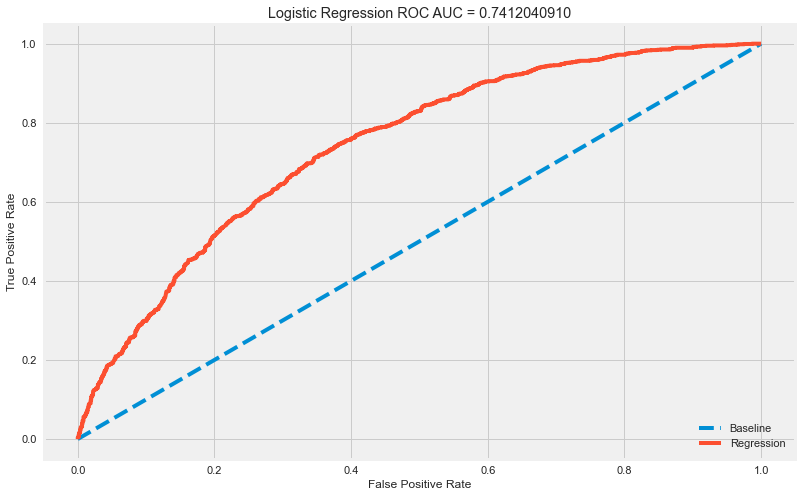

In [206]:
show_roc_auc(y_valid, y_prob[:, 1])

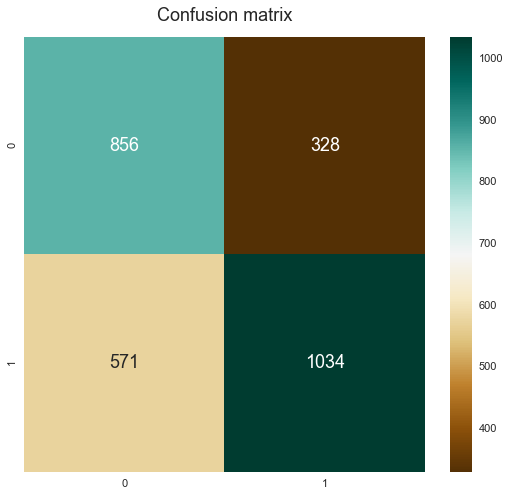

In [207]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_valid, y_pred)

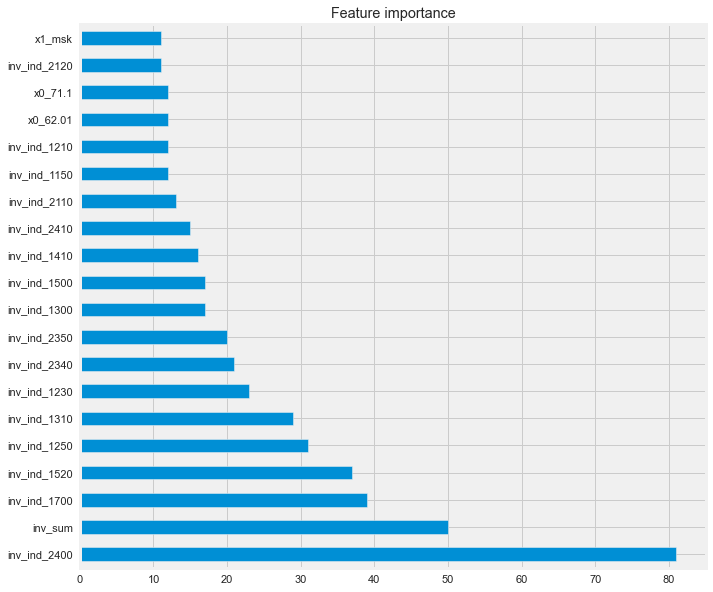

In [208]:
plot_feature_importances(model.feature_importances_, X.columns)

In [209]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob[:, 1])

0.7900438056075757

# !!! переобучились

### Предсказание срока выхода из убытков

In [210]:
# Можно попробовать разный набор фичей, но для начала возьмем сумму инвестиций и ОКВЕД
features = ['inv_sum']
#features = ['inv_sum', 'inv_ind_1500', 'inv_ind_1200', 'inv_ind_1300', 'inv_ind_1400']
X = pd.DataFrame([], index=work_df.index)
X[features] = preprocessing.StandardScaler().fit_transform(work_df[features])
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(work_df[['main_okved', 'region']])
X[ohe.get_feature_names()] = ohe.transform(work_df[['main_okved', 'region']]).astype(int)
y = work_df['target']
X.shape, y.shape

((13942, 69), (13942,))

In [211]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X.shape, y.shape, X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,

((13942, 69), (13942,), (11153, 69), (11153,), (2789, 69), (2789,))

In [212]:
model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced', max_depth=3)
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_valid)
metrics.roc_auc_score(y_valid, y_prob, multi_class='ovr', average='weighted')

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [ ]:
cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovr_weighted')

In [213]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(X, y):
    model = LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced')
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    print(metrics.roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted'))
#cross_val_score(model, X, y, cv=5, scoring='roc_auc_ovo_weighted')

0.6028434015263832
0.602741246844184
0.6111563255872219
0.6058501479679841
0.5975398424780581


На самом деле для такого набора признаков и модели без настроенных гиперпараметров результат просто поразительный, следовательно нужно искать где
в предыдущих раскладках ошибка

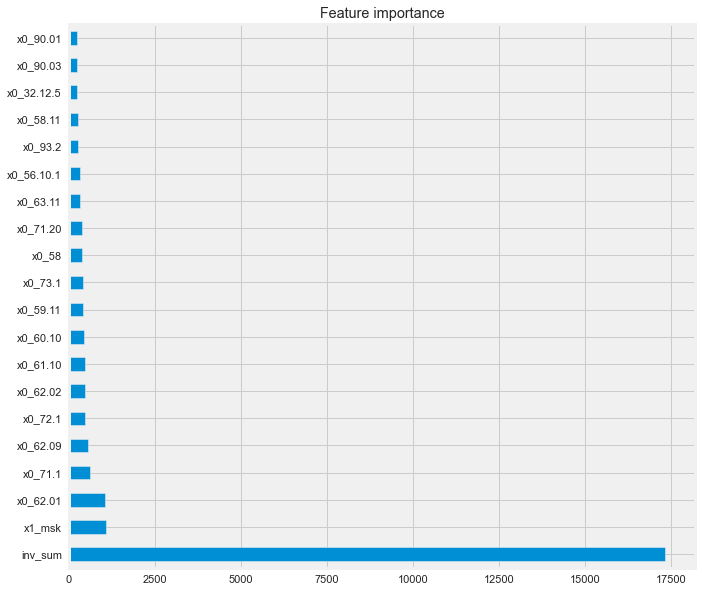

In [214]:
plot_feature_importances(model.feature_importances_, X.columns)

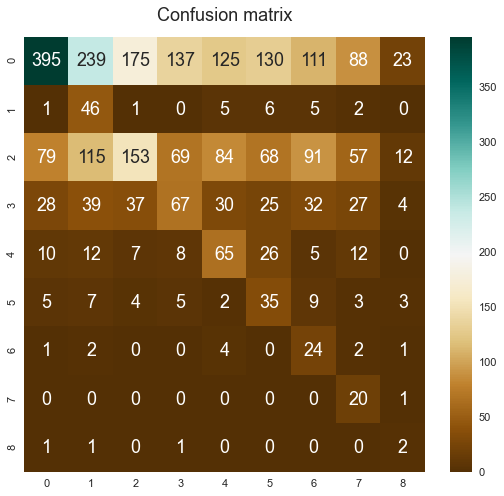

In [215]:
y_pred = model.predict(X_valid)
show_confusion_matrix(y_pred, y_valid)

In [216]:
list(zip(y_pred, y_valid))[100:110]

[(3, -1),
 (4, 2),
 (5, -1),
 (3, -1),
 (3, 3),
 (4, 4),
 (6, -1),
 (7, 1),
 (1, 1),
 (-1, -1)]

In [217]:
# По замечаниям - проверка на переобучение
y_prob = model.predict_proba(X_train)
metrics.roc_auc_score(y_train, y_prob, multi_class='ovr', average='weighted')

0.7108440982443736

# !!!Переобучились

In [218]:
model = LGBMRegressor(random_state=RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
metrics.mean_absolute_error(y_valid, y_pred)

1.2073488873374119

In [219]:
list(zip(np.round(y_pred), y_valid))[100:110]

[(0.0, -1),
 (1.0, 2),
 (0.0, -1),
 (1.0, -1),
 (1.0, 3),
 (-0.0, 4),
 (0.0, -1),
 (1.0, 1),
 (1.0, 1),
 (-0.0, -1)]

In [220]:
np.unique(np.round(y_pred), return_counts=True)

(array([-1.,  0.,  1.,  2.,  3.]), array([ 113, 1797,  801,   76,    2]))